### Wells Fargo NLP and Machine Learning Project

Created by Yi-Ching (Leslie) Lin <br>

03 July 2022

In [1]:
# for data manipulation
import pandas as pd
import numpy as np
# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image
# for processing
import re
import nltk
# for resampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
# Import modules for feature engineering and modelling
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler 
# for bag-of-words
from sklearn import feature_extraction
from sklearn import pipeline
from sklearn import preprocessing 
from sklearn.feature_extraction.text import TfidfVectorizer
# for evaluation
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# for building model
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

np.random.seed (708)

### Exploratory Data Analysis (EDA) 
#### (Reference analytic process-flow diagram 1.)
- Check for missing values.
- Visualize the distribution of the category, getting an understanding on whether the dataset is imbalanced.


In [2]:
# data file name
train_data_file = 'dbb4c4ff1f31-CAC+2022_Training+Data+Set+New.xlsx'
use_data_file = 'dbb4c4ff1f31-CAC+2022_Test+Data+Set+New.xlsx'
# define useful features
text_col = 'coalesced_brand'
num_col = 'amt'
target_col ='Category'
def data_preparation(train_data_file, use_data_file):
	"""Function to load data sets and merge training set and test set to big full set for feature engineering and data cleaning"""
	global df, use_df, dtf
	# read training data as a pandas dataframe
	df = pd.read_excel(train_data_file)
	use_df = pd.read_excel(use_data_file)
	# merge two files for data manipulation
	dtf = pd.concat([df, use_df])
	return dtf
dtf = data_preparation(train_data_file, use_data_file)

In [3]:
# check null values
dtf.isnull().sum()

sor                               0
cdf_seq_no                        0
trans_desc                        0
merchant_cat_code             19022
amt                               0
db_cr_cd                        378
payment_reporting_category        0
payment_category                  0
is_international                  0
default_brand                     0
default_location                  6
qrated_brand                   4164
coalesced_brand                   0
Category                      10000
dtype: int64

<AxesSubplot:xlabel='Category'>

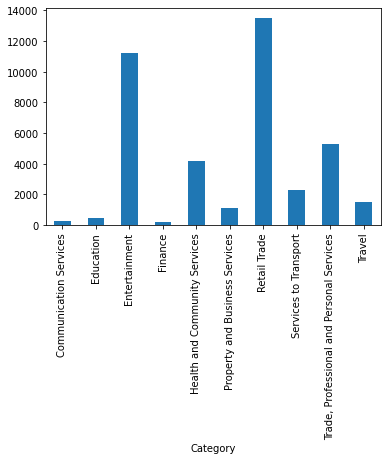

In [4]:
# visualize class distributions
df.groupby(target_col).size().plot.bar()

#### Visualization - Word Clound
The following word clouds for each category can give us a view on the major words in each category. <br>
<br>
Reference:<br>
https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5 <br>

In [5]:
# build customized stopwords list
lst_stopwords = ['and','the','of','com','www','company','co','by','to','at', 'by','for']
stopwords = set(lst_stopwords)
# get list of categories
classes = np.unique(df[target_col])
path = '/Users/linyijing/Downloads/'
image = 'dollar_image.jpeg'
mask = np.array(Image.open(path+image))
# dollar sign image from https://stock.adobe.com/uk/
def Compare_WordCloud(text, target, classes, mask):
	"""Function to generate word cloud for each category"""
	wc =  WordCloud(width=400,height=300, stopwords=lst_stopwords, colormap='hsv', max_words=400,
				   mode='RGBA', mask=mask, max_font_size= 40, min_font_size=5, random_state=73)
	for category in classes:
		wc.generate(text[target == category].to_string())
		# color of Wells Fargo reference from https://www.schemecolor.com/wells-fargo-logo-colors.php	
		font = {'family':'Latin Modern Roman','color':'#FFFF00','size':25, 'weight':'bold'}
		plt.figure(figsize=(16, 13), dpi=300, facecolor='#CD1409')
		plt.imshow(wc, interpolation='bilinear', alpha=0.98)
		plt.title(category, fontdict = font)
		plt.axis('off')
		plt.tight_layout(pad=0)
		plt.show()
Compare_WordCloud(df[text_col], df[target_col], classes, mask)

As we can see from the ablove class distribution, the dataset is extremely imbalanced. Thus, it is necessary to apply over-sampling process on the data before training the machine learning model.

### Data preparation/ Feature engineering
#### (Reference analytic process-flow diagram 2.)

- Clean merchant_cat_code column, replacing missing values with 0.
- Combine cleaned merchant_cat_code to coalesced_brand to get a more precise description on transaction.

In [6]:
def standardize(df,col):
    """Function to standardize numeric column"""
    mm_scaler = preprocessing.StandardScaler()
    amt_minmax = mm_scaler.fit_transform(df[col].to_frame())
    df[col] = amt_minmax
    return df[col]
dtf[num_col] = standardize(dtf,num_col)

### Text Preprocessing
#### (Reference analytic process-flow diagram 3.)

- Remove punctuation, stop words and tranfer nessasary word into its root word.
- Combine category code to coalesced_brand column.


In [7]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    """Function to remove puncturations, numbers and optional stemming, lemmatization and stopwords removal"""
    # clean data: convert to lowercase,remove punctuations and characters and strip
    text = re.sub('&', 'and', str(text).lower().strip())
    text = re.sub(r'[^\w\s]+', ' ', str(text).lower().strip())
    text = re.sub(r'[0-9]+', '', str(text).lower().strip())
    # tokenize (convert from string to list)
    lst_text =text.split()
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]
    # stemming 
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
    # lemmatisation
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
    # convert list of words back to its original form
    text = " ".join(lst_text)
    return text
# try different combinations of cleaning options and find out included just stopwords has the best performance
dtf.loc[:,text_col] = dtf.loc[:,text_col].apply(
    lambda x: utils_preprocess_text(x, 
                                    flg_stemm=False, 
                                    flg_lemm=False,
                                    lst_stopwords=None
 )
)

In [8]:
# inspect the patterns to fine tune misclassified transactions
dtf[text_col] = dtf[text_col].str.replace(r'^(\b[a-z]{1})\sand\s([a-z]{1}$)',r'\1\2', regex=True)
dtf[text_col] = dtf[text_col].str.replace(r'([a-z]{1})\s([a-z]{1}\smart)',r'\1\2', regex=True)
dtf[text_col] = dtf[text_col].str.replace(r'([a-z]{1})\s([a-z]{1}\smarket)',r'\1\2', regex=True)
dtf[text_col] = dtf[text_col].str.replace(r'([a-z]{1})\s([a-z]{1}\sperformance)',r'\1\2', regex=True)
dtf[text_col] = dtf[text_col].str.replace(r'(?<=\b[a-z]) (?=[a-z]\b)', '', regex=True)

In [9]:
def combine_code_brand(df, code, text_col):
    """Function to combine category code column to coalesced_brand column"""
    df.loc[:,code] = df[code].fillna(0).astype(int)
    df.loc[:,text_col] = df[code].astype(str)+' '+df[text_col].astype(str)
    df.loc[:,text_col] = df.loc[:,text_col].str.replace(r'^(0+)', '')
    df.loc[:,text_col] = df.loc[:,text_col].str.replace(r'^\s(1+)\s', '')
    return df[text_col]
dtf[text_col] = combine_code_brand(dtf, 'merchant_cat_code',text_col)

/var/folders/z1/r593y20957vb8wky88kwc2tr0000gn/T/ipykernel_51766/2460656816.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:,text_col] = df.loc[:,text_col].str.replace(r'^(0+)', '')
/var/folders/z1/r593y20957vb8wky88kwc2tr0000gn/T/ipykernel_51766/2460656816.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:,text_col] = df.loc[:,text_col].str.replace(r'^\s(1+)\s', '')


### Split the big full data back into original training set and test set
#### (Reference analytic process-flow diagram 4.)


In [10]:
# split the data back into training data and test data after feature cleaning and engineering
df = dtf.iloc[:40000,:]
use_df = dtf.iloc[40000:,:]

# split the labeled dataset into features and target variable
label_features = df[[text_col, num_col]]
label_target = df[target_col]

### Random oversampling
#### (Reference analytic process-flow diagram 5.)

Since our data is imbalanced, it required over-oversampling to balance the class distribution before feeding the training set into the machine learning model to address imbalanced dataset. Random oversampling involves randomly duplicating examples from the minority class and adding them to the training dataset.
######
Reference:<br>
https://medium.com/@satishkorapati/dealing-with-imbalanced-dataset-for-multi-class-text-classification-having-multiple-categorical-2a43fc8de009

In [11]:
test_size = 0.2
def ros(df, independent_set, target_variable, test_size):
    """Achieve a balanced training and validation after over-sampling original data set"""
    global X_ROS, y_ROS, X_train_ros, X_test_ros, y_train_ros, y_test_ros
    ros = RandomOverSampler(random_state=777)
    X_ROS, y_ROS = ros.fit_sample(df[independent_set], df[target_variable].to_frame())
    X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_ROS, y_ROS, test_size = test_size)
ros(df,[text_col, num_col], target_col, test_size)

In [12]:
def frac(dataframe, fraction):
    """Return fraction of data to evaluate model performance"""
    return dataframe.sample(frac=fraction)
## try different proportion of training set and test set to evaluate model performance
#train_10 = frac(df, 0.5)
#X_train_10, X_test_10, y_train_10, y_test_10 = train_test_split(train_10[['coalesced_brand','amt']], train_10['Category'], test_size = 0.2)

<AxesSubplot:xlabel='Category'>

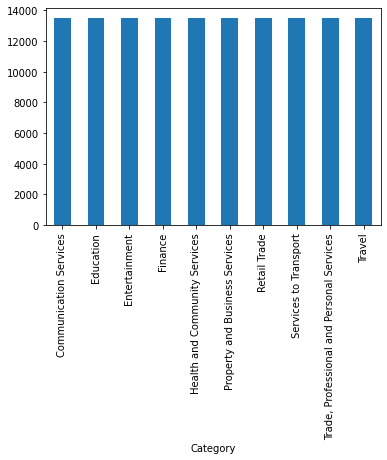

In [13]:
# visualize categories distribution after over-sampling
y_ROS.groupby(target_col).size().plot.bar()

Perfect! As we can see from the above bar plot, after over resampling the dataset, now we have the dataset that is well balanced!<br>
We will then start building bag of words (BOW) with optimal vectorizer.

### Pipeline
#### (Reference analytic process-flow diagram 6.)

- Select numeric and text column
- build corpus and vectorizer
- Synthetic minority oversampling on ROS dataset to create more data for training model
- Grid search on vectorizer and SVM model
- Train the linear SVM model and evaluate its performance on test data
####
Reference:<br>
https://www.kaggle.com/code/selener/multi-class-text-classification-tfidf/notebook <br>
https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f

In [14]:
# create function to extract columns with different data type seperately
get_text_data = FunctionTransformer(lambda x: x[text_col], validate=False)
# convert numeric variable into 2d array to fit the model
get_numeric_data = FunctionTransformer(lambda x: x[num_col].to_frame())
# use imbalanced pipeline to tranform data into model digestable form and fed the data into classifier
pipeline = imbpipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('extract', get_numeric_data),
                ('scale', StandardScaler())         
  ]
 )
),
             ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vec', TfidfVectorizer(#vocabulary= X_names,
                                        stop_words= None,
                                        ngram_range= (1,3), 
                                        max_df= 0.3, # very useful on imbalanced dataset
                                        min_df= 0
       )
      )
     ]
    )
   )
  ]
 )
),
    ('smote', SMOTE(random_state=28)),
    ('clf', SGDClassifier(max_iter=50,
                          tol=0.001, 
                          alpha=1e-06, 
                          penalty='l2'
   )
  )
 ]
)
# Grid Search Parameters for SGD 
param_grid = {#'vec__max_df': (0.3, 0.2, 0.4),
              #'vec__min_df': (0,1,2),
              #'vec__ngram_range': [(1,3)], 
              #'clf__alpha': (0.00001, 0.000001, 0.000005),
              #'clf__panelty': ('l2','l1'),
              'clf__max_iter': [50],
              #'clf__tol': (0, 1e-1, 1e-2, 1e-3, 1e-5)
}
# Perform GridSearch
sgd_model = GridSearchCV(pipeline, 
                         param_grid=param_grid, 
                         cv=5,
                         #n_jobs=-1, 
                         return_train_score=True, 
                         verbose=1
)
# fit the model on all labeled data
sgd_model.fit(label_features, label_target.values.ravel())

# store the result of best hyperparameter to variable
sgd_best = sgd_model.best_estimator_
# predict on test data
pred_combine = sgd_model.predict(X_test_ros)
# accuray
print('accuracy %s' % accuracy_score(y_test_ros[target_col], pred_combine)) 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.0min finished


accuracy 1.0


### Model Performance Evaluation
#### (Reference analytic process-flow diagram 7.)

Accuracy/ F-1 score high enough (> 0.99) 
- Inspect numbers of misclassified transactions and output them as a dataframe (if any)
- Classification report
- Confusion matrix

In [15]:
def inspect_misclassfied_transactions(target_var, features_var, predictions):
    """Function to inspect misclassified transactions"""
    target_var.loc[:,'predict'] = predictions
    inspect=pd.concat([target_var,features_var],axis = 1)
    inspect_misclassified = inspect[inspect['predict'] != inspect[target_col]]
    print(len(inspect_misclassified.value_counts(text_col)))
    inspect_misclassified.sort_values(text_col)
inspect_misclassfied_transactions(y_test_ros, X_test_ros, pred_combine)

0


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [16]:
# print out metrices of classification report
print(classification_report(y_test_ros['Category'], y_test_ros.loc[:,'predict'], target_names=classes))

                                           precision    recall  f1-score   support

                   Communication Services       1.00      1.00      1.00      2708
                                Education       1.00      1.00      1.00      2763
                            Entertainment       1.00      1.00      1.00      2633
                                  Finance       1.00      1.00      1.00      2743
            Health and Community Services       1.00      1.00      1.00      2669
           Property and Business Services       1.00      1.00      1.00      2655
                             Retail Trade       1.00      1.00      1.00      2694
                    Services to Transport       1.00      1.00      1.00      2697
Trade, Professional and Personal Services       1.00      1.00      1.00      2729
                                   Travel       1.00      1.00      1.00      2709

                                 accuracy                           1.00     27000
  

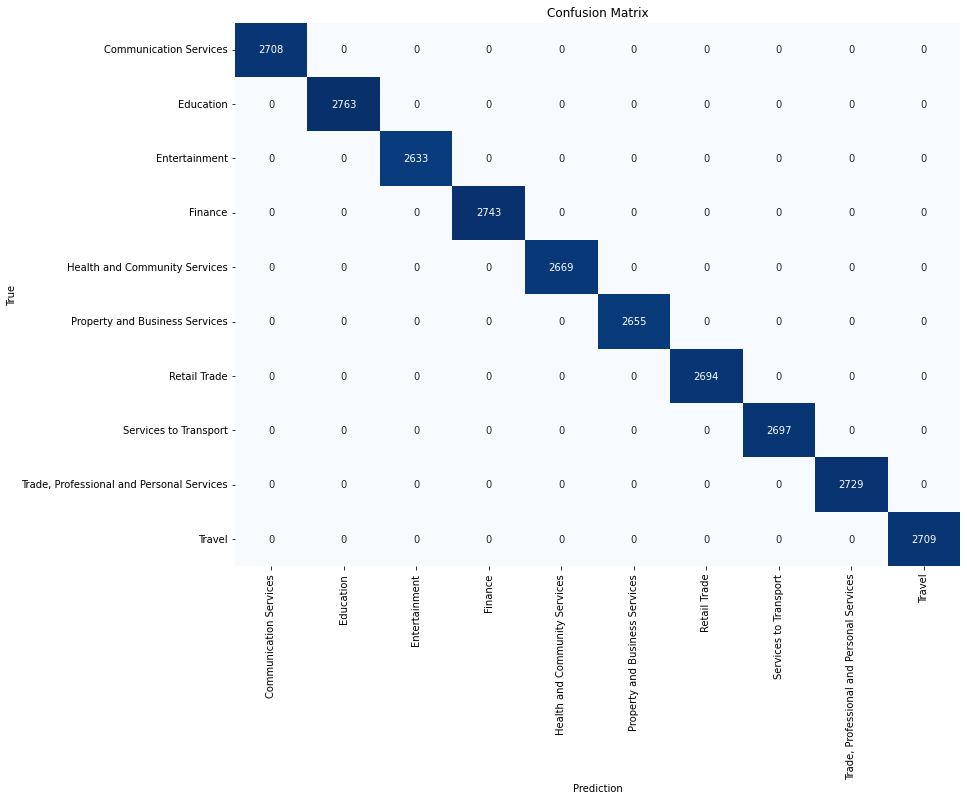

In [17]:
ture = y_test_ros[target_col]
predict = y_test_ros['predict']
def plot_confusion_matrix(ture, predict, cmap=plt.cm.Blues):
    """Function to plot confusion matrix"""
    cm = confusion_matrix(ture,predict)
    fig, ax = plt.subplots(figsize=(13,10))
    sns.heatmap(cm,
                annot=True, 
                fmt='d', 
                ax=ax, 
                cmap = cmap,
                cbar=False
                )
    ax.set(xlabel='Prediction', 
           ylabel='True', 
           xticklabels=classes, 
           yticklabels=classes, 
           title='Confusion Matrix')
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.show()
plot_confusion_matrix(ture, predict)

As we can see from the above confusion matrix, the outcome is perfectly diagonal with zero transaction misclassified.

### Output prediction of test data 
- Read in origianl test dataset
- Make predictions on cleaned test data (use_df)
- Append the predictions on category to orginal test dataset
- Output predictions and save the file
#### (Reference analytic process-flow diagram 8.)


In [18]:
file_name = 'Wells_Fargo_Predictions.csv'
def output_prediction(model, use_case, use_data_file):
    """Output predictions to Excel file"""
    global test_df
    # load raw used case file
    test_df = pd.read_excel(use_data_file)
    # make prediction on cleaned test data 
    pred_combine = model.predict(use_case)
    # output predictions to file
    test_df.loc[:,target_col] = pred_combine
    test_df.to_csv(file_name)
    return test_df
test_df = output_prediction(sgd_model, use_df, use_data_file)